![Logo AIED26](../assets/logo_AIED26.png)

# **Notebook#02 : Analysis on RQ1**
## [impact on in-game progression and learning gain]

## 1/ Imports

In [48]:
# Internal
import sys
sys.path.append("../src")
import students_constants as stu_const
import interaction_constants as int_const
import tests_constants  as tes_const

# External
import pandas as pd
from scipy import stats
import numpy as np
import rpy2.ipython

In [49]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## 2/ Data importation

In [2]:
interaction_data = pd.read_pickle("../data/interim/interaction_data.pkl")
pre_test_data = pd.read_pickle("../data/interim/pre_test_data.pkl")
post_test_data = pd.read_pickle("../data/interim/post_test_data.pkl")

## 3/ In-game progression [A/B/C]

### 3.1/ Calculate game progression (index 0-100)

In [3]:
# Get all STARTED actions to find maximum level reached by each student
started_actions = interaction_data[
    interaction_data[int_const.ACTION_DATA_KEY] == int_const.STARTED_ACTION
]

# Find maximum level reached by each student
max_level_per_student = started_actions.groupby(
    int_const.GAME_ID_DATA_KEY
)[int_const.LEVEL_DATA_KEY].max()

print(f"Number of games detected: {len(max_level_per_student)}")

student_progress_data = []

for game_id in max_level_per_student.index:
    max_level = max_level_per_student[game_id]
    
    # Get all traces for this student at his maximum level
    student_level_data = interaction_data[
        (interaction_data[int_const.GAME_ID_DATA_KEY] == game_id) & 
        (interaction_data[int_const.LEVEL_DATA_KEY] == max_level)
    ]
    
    # Maximum progression
    max_progression = student_level_data[int_const.GAME_PROGRESSION_DATA_KEY].max()
    
    # Group id
    group = student_level_data[int_const.GROUP_ID_DATA_KEY].iloc[0]

    # Results aggregation 
    student_progress_data.append({
        'game_id': game_id,
        'group_id': group,
        'max_level': max_level,
        'max_progression': max_progression
    })

# Create progress dataframe
progress_df = pd.DataFrame(student_progress_data)

# Calculate progress index (0-100 points)
# - Each completed level gives 12.5 points (100/8)
# - For current level, progression percentage gives fraction of 12.5 points
def calculate_progress_index(max_level, max_progression):
    completed_levels_points = (max_level - 1) * (100 / 8)
    current_level_points = (max_progression / 100) * (100 / 8)
    return min(completed_levels_points + current_level_points, 100)

progress_df['progress_index'] = progress_df.apply(
    lambda row: calculate_progress_index(row['max_level'], row['max_progression']),
    axis=1
)

print(f"Number of progress entries computed: {len(progress_df)}")
# Export to Excel for debug
progress_df.to_excel("../debug/debug_students_game_progression.xlsx")


Number of games detected: 248
Number of progress entries computed: 248


### 3.2/ Test A VS (B+C)

Is there a difference in game progression between students from group A and students from group B+C ?

In [4]:
# Extract progress data for each group
group_a_progress = progress_df[progress_df['group_id'] == 'A']['progress_index']
group_b_progress = progress_df[progress_df['group_id'] == 'B']['progress_index']
group_c_progress = progress_df[progress_df['group_id'] == 'C']['progress_index']
# Combine B and C into one group
group_bc_progress = pd.concat([group_b_progress, group_c_progress])

# Descriptive statistics
average_progress_A = group_a_progress.mean()
average_progress_BC = group_bc_progress.mean()

std_progress_A = group_a_progress.std()
std_progress_BC = group_bc_progress.std()

mean_diff = average_progress_BC - average_progress_A
percent_increase = (mean_diff / average_progress_A) * 100

print("=== DESCRIPTIVE STATISTICS ===")
print(f"Group A: n = {len(group_a_progress)}, mean = {average_progress_A:.2f}, std = {std_progress_A:.2f}")
print(f"Group B+C: n = {len(group_bc_progress)}, mean = {average_progress_BC:.2f}, std = {std_progress_BC:.2f}")
print(f".   Difference in mean (B+C - A): {mean_diff:.2f}")
print(f".   Percentage increase from Group A: {percent_increase:.2f}%")

=== DESCRIPTIVE STATISTICS ===
Group A: n = 81, mean = 63.83, std = 23.74
Group B+C: n = 167, mean = 67.41, std = 23.08
.   Difference in mean (B+C - A): 3.58
.   Percentage increase from Group A: 5.61%


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula
   Data: df

REML criterion at convergence: 2170.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5165 -0.8370 -0.1760  0.8238  1.8150 

Random effects:
 Groups      Name        Variance Std.Dev.
 X_school_id (Intercept)  89.19    9.444  
 Residual                477.41   21.850  
Number of obs: 241, groups:  X_school_id, 5

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)       66.179      4.920   5.663  13.451 1.63e-05 ***
X_group_id_BCBC    5.748      3.075 237.598   1.869   0.0628 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
X_grp__BCBC -0.405

- ANOVA for: X_progress_index ~ X_group_id_BC + (1 | X_school_id) with df_all 
Analysis of Deviance Table (Type III Wald chisquare tests)

Response: X_progress_index
                 Chisq Df Pr(>Chisq)    

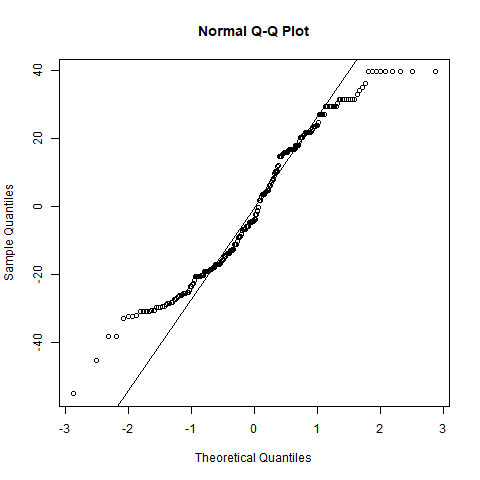

In [42]:
%%R
options(encoding = "UTF-8")
Sys.setenv(LANGUAGE = "en")
Sys.setlocale("LC_ALL", "English_United States.UTF-8")
source("../src/utils_stats.R")

summary(df_all)
df_A = subset(df_all, X_group_id == "A")
df_B = subset(df_all, X_group_id == "B")
df_C = subset(df_all, X_group_id == "C")
df_BC = subset(df_all, X_group_id != "A")


result = run_lmer_pipeline(df = df_all, df_name="df_all", dep = "X_progress_index", fixed_factors = "X_group_id_BC", random_factors = "(1 | X_school_id)")

print("\n\nFinal models \n")
print(result)

### 3.3/ Test A VS B VS C

Is there a difference in game progression between students from groups A, B, and C?

In [6]:
# Descriptive statistics
average_progress_A = group_a_progress.mean()
average_progress_B = group_b_progress.mean()
average_progress_C = group_c_progress.mean()

diff_B = average_progress_B - average_progress_A
percent_increase_B = (diff_B / average_progress_A) * 100

diff_C = average_progress_C - average_progress_A
percent_increase_C = (diff_C / average_progress_A) * 100


print("=== DESCRIPTIVE STATISTICS ===")
print(f"Group A: n = {len(group_a_progress)}, mean = {average_progress_A:.2f}, std = {group_a_progress.std():.2f}")
print(f"Group B: n = {len(group_b_progress)}, mean = {average_progress_B:.2f}, std = {group_b_progress.std():.2f}")
print(f".   diff vs A = {diff_B:.2f}, increase = {percent_increase_B:.2f}%")
print(f"Group C: n = {len(group_c_progress)}, mean = {average_progress_C:.2f}, std = {group_c_progress.std():.2f}")
print(f".   diff vs A = {diff_C:.2f}, increase = {percent_increase_C:.2f}%")

=== DESCRIPTIVE STATISTICS ===
Group A: n = 81, mean = 63.83, std = 23.74
Group B: n = 94, mean = 65.88, std = 22.19
.   diff vs A = 2.04, increase = 3.20%
Group C: n = 73, mean = 69.40, std = 24.19
.   diff vs A = 5.56, increase = 8.71%


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula
   Data: df

REML criterion at convergence: 2163.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4491 -0.7663 -0.1211  0.8898  1.7821 

Random effects:
 Groups      Name        Variance Std.Dev.
 X_school_id (Intercept) 114.2    10.69   
 Residual                472.5    21.74   
Number of obs: 241, groups:  X_school_id, 5

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   66.744      5.409   5.196  12.339 4.78e-05 ***
X_group_idB    8.629      3.519 237.511   2.452   0.0149 *  
X_group_idC    1.586      4.021 235.801   0.394   0.6937    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) X_gr_B
X_group_idB -0.289       
X_group_idC -0.317  0.343

- ANOVA for: X_progress_index ~ X_group_id + (1 | X_school_id) with df_all 
Analysis of Deviance Table (Type III Wald

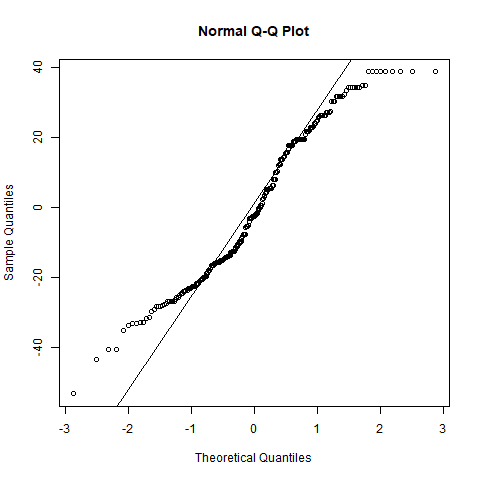

In [43]:
%%R
result = run_lmer_pipeline(df = df_all, df_name="df_all", dep = "X_progress_index", fixed_factors = "X_group_id", random_factors = "(1 | X_school_id)")

print("\n\nFinal models \n")
print(result)

## 4/ Learning gain [A/B/C]

### 4.1/ Learning gain calculation

The learning gain calculation is based on ANSWERS_SCORES dictionary (see `scr/tests_constants.py`)

In [8]:
# Calculate maximum score
max_score_general = sum(max(answer.values()) for answer in tes_const.ANSWERS_SCORES.values())

# Score calculation function
def calculate_score(student, max_score):
    score = 0
    for question, answer in student.items():
        if question in tes_const.ANSWERS_SCORES and answer in tes_const.ANSWERS_SCORES[question]:
            score += tes_const.ANSWERS_SCORES[question][answer]
    return round((score/max_score)*100)

groups = [tes_const.GROUP_A, tes_const.GROUP_B, tes_const.GROUP_C]
scores_data = {}

for group in groups:
    # Filter and calculate scores
    pre_temp = pre_test_data[pre_test_data[tes_const.GROUP_ID_KEY] == group].copy()
    post_temp = post_test_data[post_test_data[tes_const.GROUP_ID_KEY] == group].copy()
    
    pre_temp['pre_score'] = pre_temp.apply(calculate_score, axis=1, max_score=max_score_general)
    post_temp['post_score'] = post_temp.apply(calculate_score, axis=1, max_score=max_score_general)
    
    # Merge and calculate gain
    scores_df = pd.merge(
        pre_temp[[tes_const.STUDENT_ID_KEY, 'pre_score']],
        post_temp[[tes_const.STUDENT_ID_KEY, 'post_score']],
        on=tes_const.STUDENT_ID_KEY,
        how='inner' # the student must have a pre-test score AND a post-test score
    )
    scores_df['learning_gain'] = scores_df['post_score'] - scores_df['pre_score']
    
    scores_data[group] = scores_df
    print(f"Group {group}: {len(scores_df)}/{sum(1 for s in stu_const.ALL_STUDENTS if s[stu_const.GROUP_ID] == group)} students with both pre and post tests")
    
    # Export
    scores_df.to_excel(f"../debug/debug_learning_gain_{group}.xlsx", index=False)


Group A: 73/81 students with both pre and post tests
Group B: 90/94 students with both pre and post tests
Group C: 72/73 students with both pre and post tests


### 4.2/ Intra-group learning gain analysis

Do students demonstrate learning gains using Pyrates in their respective groups?

In [9]:
alpha = 0.05
groups = [tes_const.GROUP_A, tes_const.GROUP_B, tes_const.GROUP_C]
for group in groups:
    scores_df = scores_data[group]
    pre_scores = scores_df['pre_score']
    post_scores = scores_df['post_score']
    learning_gains = scores_df['learning_gain']
    print(f"\n=======================================")
    print(f"GROUP {group} INTRA-GROUP ANALYSIS")
    print(f"========================================")

    print("\n=== DESCRIPTIVE STATISTICS ===")

    print(f"Pre-test: M = {pre_scores.mean():.2f}, SD = {pre_scores.std():.2f}")
    print(f"Post-test: M = {post_scores.mean():.2f}, SD = {post_scores.std():.2f}")
    print(f"Learning gain: M = {learning_gains.mean():.2f}, SD = {learning_gains.std():.2f}")
    
    print(f"\n=== NORMALITY TESTS (Shapiro-Wilk) ===")
    # Shapiro-Wilk test for pre-post differences
    shapiro_gain = stats.shapiro(learning_gains)
    print(f"Shapiro-Wilk test for learning gains: p-value = {shapiro_gain.pvalue:.4f}")
    
    # Check normality
    if shapiro_gain.pvalue >= alpha:
        print("Learning gains are normally distributed -> Paired T-test is applicable.")
        normal_distribution = True
    else:
        print("Learning gains are not normally distributed -> Prefer Wilcoxon test.")
        normal_distribution = False
    
    print(f"\n=== TEST RESULTS ===")
    # Paired T-test
    t_test = stats.ttest_rel(pre_scores, post_scores)
    print(f"Paired T-test: t = {t_test.statistic:.4f}, p-value = {t_test.pvalue:.4f}")
    
    # Wilcoxon signed-rank test
    wilcoxon_test = stats.wilcoxon(pre_scores, post_scores)
    print(f"Wilcoxon test: W = {wilcoxon_test.statistic:.4f}, p-value = {wilcoxon_test.pvalue:.4f}")
    
    # Choose appropriate test based on normality
    if normal_distribution:
        recommended_pvalue = t_test.pvalue
        test_used = "Paired T-test"
    else:
        recommended_pvalue = wilcoxon_test.pvalue
        test_used = "Wilcoxon test"

    # Calculate effect sizes
    n = len(learning_gains)
    
    # Cohen's d for paired samples (using learning gains)
    cohens_d = learning_gains.mean() / learning_gains.std()
    
    # r effect size for Wilcoxon (using z-score approximation)
    z_wilcoxon = stats.norm.ppf(1 - wilcoxon_test.pvalue / 2)
    r_wilcoxon = z_wilcoxon / np.sqrt(n)


    # Choose appropriate test based on normality
    if normal_distribution:
        recommended_pvalue = t_test.pvalue
        test_used = "Paired T-test"
        effect_size = cohens_d
        effect_label = "Cohen's d"
        
        # Interpret Cohen's d
        if abs(cohens_d) < 0.2:
            effect_interpretation = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_interpretation = "small"
        elif abs(cohens_d) < 0.8:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
    else:
        recommended_pvalue = wilcoxon_test.pvalue
        test_used = "Wilcoxon test"
        effect_size = r_wilcoxon
        effect_label = "r"
        
        # Interpret r
        if abs(r_wilcoxon) < 0.1:
            effect_interpretation = "negligible"
        elif abs(r_wilcoxon) < 0.3:
            effect_interpretation = "small"
        elif abs(r_wilcoxon) < 0.5:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
    
    # Interpretation
    print(f"Results (using {test_used}) :")
    
    if recommended_pvalue < alpha:
        print(f"SIGNIFICANT: p-value = {recommended_pvalue:.4f} < alpha = {alpha}")
        if learning_gains.mean() > 0:
            print(f"   Significant learning gain observed (+{learning_gains.mean():.2f} points)")
        else:
            print(f"   Significant learning loss observed ({learning_gains.mean():.2f} points)")
    else:
        print(f"NOT SIGNIFICANT: p-value = {recommended_pvalue:.4f} > alpha = {alpha}")
        print("   No significant learning gain observed")

    # Display effect size
    print(f"Effect Size")
    print(f"{effect_label} = {effect_size:.4f}")
    print(f"Effect size interpretation: {effect_interpretation}")



GROUP A INTRA-GROUP ANALYSIS

=== DESCRIPTIVE STATISTICS ===
Pre-test: M = 45.14, SD = 16.84
Post-test: M = 55.26, SD = 20.65
Learning gain: M = 10.12, SD = 18.10

=== NORMALITY TESTS (Shapiro-Wilk) ===
Shapiro-Wilk test for learning gains: p-value = 0.0457
Learning gains are not normally distributed -> Prefer Wilcoxon test.

=== TEST RESULTS ===
Paired T-test: t = -4.7788, p-value = 0.0000
Wilcoxon test: W = 320.0000, p-value = 0.0001
Results (using Wilcoxon test) :
SIGNIFICANT: p-value = 0.0001 < alpha = 0.05
   Significant learning gain observed (+10.12 points)
Effect Size
r = 0.4739
Effect size interpretation: medium

GROUP B INTRA-GROUP ANALYSIS

=== DESCRIPTIVE STATISTICS ===
Pre-test: M = 42.89, SD = 19.79
Post-test: M = 52.88, SD = 22.44
Learning gain: M = 9.99, SD = 17.79

=== NORMALITY TESTS (Shapiro-Wilk) ===
Shapiro-Wilk test for learning gains: p-value = 0.0166
Learning gains are not normally distributed -> Prefer Wilcoxon test.

=== TEST RESULTS ===
Paired T-test: t = -5

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula
   Data: df

REML criterion at convergence: 619.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.00749 -0.71135 -0.03391  0.71039  2.30918 

Random effects:
 Groups      Name        Variance Std.Dev.
 X_school_id (Intercept)  14.92    3.863  
 Residual                285.38   16.893  
Number of obs: 73, groups:  X_school_id, 5

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  26.2505     6.1654 41.8955   4.258 0.000114 ***
X_pre_score   0.6567     0.1214 70.6650   5.410 8.15e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
X_pre_score -0.900

- ANOVA for: X_post_score ~ X_pre_score + (1 | X_school_id) with df_A 
Analysis of Deviance Table (Type III Wald chisquare tests)

Response: X_post_score
             Chisq Df Pr(>Chisq)    
(Intercept) 18.128 

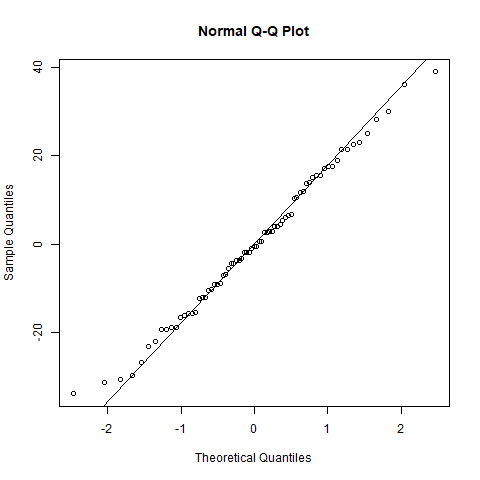

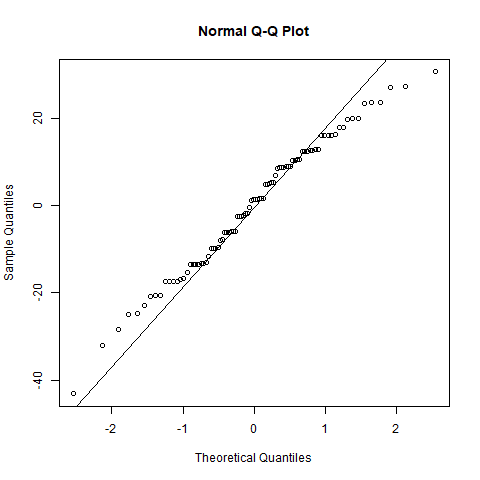

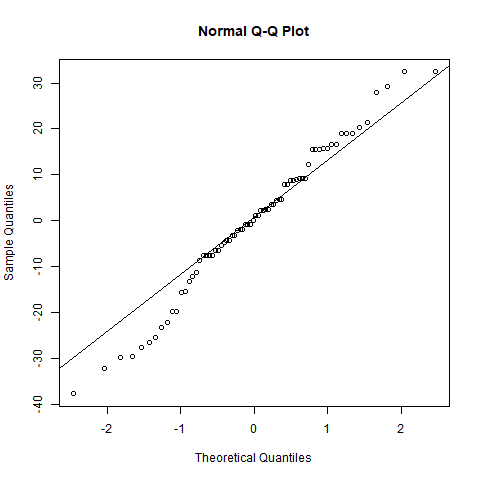

In [41]:
%%R
result = run_lmer_pipeline(df = df_A, df_name="df_A", dep = "X_post_score", fixed_factors = "X_pre_score", random_factors = "(1 | X_school_id)")
result = run_lmer_pipeline(df = df_B, df_name="df_B", dep = "X_post_score", fixed_factors = "X_pre_score", random_factors = "(1 | X_school_id)")
result = run_lmer_pipeline(df = df_C, df_name="df_C", dep = "X_post_score", fixed_factors = "X_pre_score", random_factors = "(1 | X_school_id)")

### 4.3/ Inter-group learning gain comparison

#### 4.3.1/ Test A VS (B+C)

Is there a difference in learning gains between students from group A and those from group B+C ?

In [10]:
# Extract learning gains
learning_gains_A = scores_data['A']['learning_gain']
learning_gains_BC = pd.concat([scores_data['B']['learning_gain'], scores_data['C']['learning_gain']])

# Descriptive statistics
mean_A = learning_gains_A.mean()
mean_BC = learning_gains_BC.mean()
std_A = learning_gains_A.std()
std_BC = learning_gains_BC.std()
diff_A_BC = mean_A - mean_BC
percent_reduction_BC = (diff_A_BC / mean_A) * 100

print("=== DESCRIPTIVE STATISTICS ===")
print(f"Group A (n={len(learning_gains_A)}): M = {mean_A:.2f}, SD = {std_A:.2f}")
print(f"Group B+C (n={len(learning_gains_BC)}): M = {mean_BC:.2f}, SD = {std_BC:.2f}")
print(f".   Difference (A - B+C) = {diff_A_BC:.2f}")
print(f".   Percentage reduction compared to A = {percent_reduction_BC:.2f}%")

=== DESCRIPTIVE STATISTICS ===
Group A (n=73): M = 10.12, SD = 18.10
Group B+C (n=162): M = 8.86, SD = 17.47
.   Difference (A - B+C) = 1.27
.   Percentage reduction compared to A = 12.50%


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula
   Data: df

REML criterion at convergence: 2008.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4979 -0.5015  0.1213  0.7440  2.6688 

Random effects:
 Groups      Name        Variance Std.Dev.
 X_school_id (Intercept)   0       0.00   
 Residual                312      17.66   
Number of obs: 235, groups:  X_school_id, 5

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)       10.123      2.067 233.000   4.897 1.82e-06 ***
X_group_id_BCBC   -1.265      2.490 233.000  -0.508    0.612    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
X_grp__BCBC -0.830
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


- ANOVA for: X_learning_gains ~ X_group_id_BC + (1 | X_school_id) with df_all 
Analysis of Deviance Table (Typ

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')


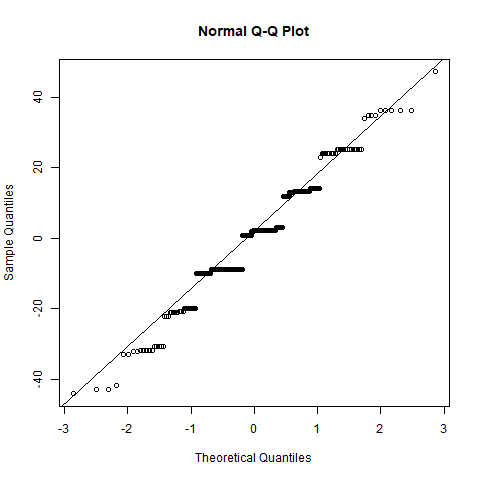

In [46]:
%%R
result = run_lmer_pipeline(df = df_all, df_name="df_all", dep = "X_learning_gains", fixed_factors = "X_group_id_BC", random_factors = "(1 | X_school_id)")

#### 4.3.2/ Test A VS B VS C

Is there a difference in learning gains between students from groups A, B, and C?

In [12]:
# Extract learning gains for each group
learning_gains_A = scores_data['A']['learning_gain']
learning_gains_B = scores_data['B']['learning_gain'] 
learning_gains_C = scores_data['C']['learning_gain']

# Descriptive statistics
average_gain_A = learning_gains_A.mean()
average_gain_B = learning_gains_B.mean()
average_gain_C = learning_gains_C.mean()
diff_B_vs_A = average_gain_A - average_gain_B
diff_C_vs_A = average_gain_A - average_gain_C

percent_reduction_B = (diff_B_vs_A / average_gain_A) * 100
percent_reduction_C = (diff_C_vs_A / average_gain_A) * 100

print("\n=== DESCRIPTIVE STATISTICS ===")
print(f"Group A (n={len(learning_gains_A)}): M = {average_gain_A:.2f}, SD = {learning_gains_A.std():.2f}")
print(f"Group B (n={len(learning_gains_B)}): M = {average_gain_B:.2f}, SD = {learning_gains_B.std():.2f}")
print(f".   B vs A: Mean difference = {diff_B_vs_A:.2f}, Percentage reduction = {percent_reduction_B:.2f}%")
print(f"Group C (n={len(learning_gains_C)}): M = {average_gain_C:.2f}, SD = {learning_gains_C.std():.2f}")
print(f".   C vs A: Mean difference = {diff_C_vs_A:.2f}, Percentage reduction = {percent_reduction_C:.2f}%")


=== DESCRIPTIVE STATISTICS ===
Group A (n=73): M = 10.12, SD = 18.10
Group B (n=90): M = 9.99, SD = 17.79
.   B vs A: Mean difference = 0.13, Percentage reduction = 1.33%
Group C (n=72): M = 7.44, SD = 17.06
.   C vs A: Mean difference = 2.68, Percentage reduction = 26.46%


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula
   Data: df

REML criterion at convergence: 2003.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.49120 -0.55867  0.06979  0.71564  2.60003 

Random effects:
 Groups      Name        Variance Std.Dev.
 X_school_id (Intercept)   4.449   2.109  
 Residual                309.531  17.594  
Number of obs: 235, groups:  X_school_id, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  10.20011    2.29360  11.26335   4.447 0.000928 ***
X_group_idB  -0.05685    2.82107 195.84189  -0.020 0.983942    
X_group_idC  -3.61314    3.07057  79.95829  -1.177 0.242807    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) X_gr_B
X_group_idB -0.632       
X_group_idC -0.639  0.452

- ANOVA for: X_learning_gains ~ X_group_id + (1 | X_school_id) with df_all 
Analysis of Devianc

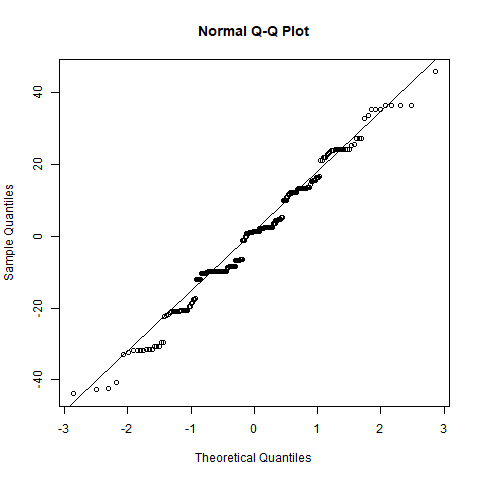

In [47]:
%%R
result = run_lmer_pipeline(df = df_all, df_name="df_all", dep = "X_learning_gains", fixed_factors = "X_group_id", random_factors = "(1 | X_school_id)")